In [1]:
import pyro
import pyro.nn.module
import pyro.distributions as dist
from pyro.distributions import Normal, Categorical
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.nn.module import PyroModule, PyroParam, PyroSample, to_pyro_module_
from pyro.infer.autoguide import AutoDiagonalNormal

import numpy as np
import matplotlib.pyplot as plt

import torch.nn
import torch.nn.functional as F
from torch import nn
from torch.nn.modules import Linear, ReLU, Sigmoid
from sklearn.datasets import make_moons

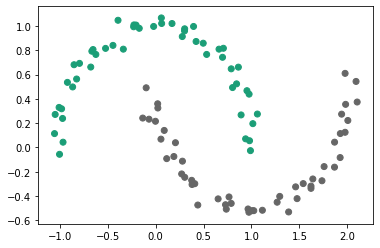

In [2]:
#Fake Data
x, y = make_moons(100, shuffle=True, noise=0.05)
plt.scatter(x[:,0],x[:,1], c=y, cmap='Dark2')

x = torch.tensor(x).float()
y = torch.tensor(y).float()

In [ ]:
class BNN(torch.nn.Module):
    def __init__(self, n_hidden=2, n_classes=2):
        super(BNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.w1 = pyro.param("w1", torch.tensor(0.0))
        self.w2 = pyro.param("w2", torch.tensor(0.0))
        self.w3 = pyro.param("w3", torch.tensor(0.0))
        self.w4 = pyro.param("w4", torch.tensor(0.0))
        self.w5 = pyro.param("w5", torch.tensor(0.0))
        self.w6 = pyro.param("w6", torch.tensor(0.0))
        self.b1 = pyro.param("b1", torch.tensor(1.0))
        self.b2 = pyro.param("b2", torch.tensor(1.0))
        self.b3 = pyro.param("b3", torch.tensor(1.0))
        self.relu = Sigmoid()
        self.sigmoid = Sigmoid()
        self.best = torch.tensor(0)
        self.best_weights = [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.b1, self.b2, self.b3]

    def propose(self):
        w1_prior = Normal(loc=torch.zeros_like(self.w1), scale=torch.ones_like(self.w1))
        w2_prior = Normal(loc=torch.zeros_like(self.w2), scale=torch.ones_like(self.w2))
        w3_prior = Normal(loc=torch.zeros_like(self.w3), scale=torch.ones_like(self.w3))
        w4_prior = Normal(loc=torch.zeros_like(self.w4), scale=torch.ones_like(self.w4))
        w5_prior = Normal(loc=torch.zeros_like(self.w5), scale=torch.ones_like(self.w5))
        w6_prior = Normal(loc=torch.zeros_like(self.w6), scale=torch.ones_like(self.w6))
        b1_prior = Normal(loc=torch.ones_like(self.b1), scale=torch.ones_like(self.b1))
        b2_prior = Normal(loc=torch.ones_like(self.b2), scale=torch.ones_like(self.b2))
        b3_prior = Normal(loc=torch.ones_like(self.b3), scale=torch.ones_like(self.b3))

        return [w1_prior.sample(), w2_prior.sample(), w3_prior.sample(), w4_prior.sample(), w5_prior.sample(), w6_prior.sample(), b1_prior.sample(), b2_prior.sample(), b3_prior.sample()]
    
    def forward(self, x):
        [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.b1, self.b2, self.b3] = self.propose()
        self.layer1w = torch.tensor([[self.w1,self.w2], [self.w3,self.w4]])
        self.layer1b = torch.tensor([[self.b1,self.b2]])
        self.layer2w = torch.tensor([[self.w5,self.w6]])
        self.layer2b = torch.tensor([[self.b3]])
        output = torch.mm(x, torch.t(self.layer1w)) + self.layer1b
        output = self.relu(output)
        output = torch.mm(output, torch.t(self.layer2w)) + self.layer2b
        output = self.sigmoid(output)
        self.accuracy(output)
        return output
    
    def accuracy(self, output):
        acc = torch.sum(torch.round(output)[:,0] == y)
        #print(acc)
        if acc.item() > self.best.item():
            self.best = acc
            self.best_weights = [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.b1, self.b2, self.b3]

    def forward_best(self, x):
        [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.b1, self.b2, self.b3] = self.best_weights
        self.layer1w = torch.tensor([[self.w1,self.w2], [self.w3,self.w4]])
        self.layer1b = torch.tensor([[self.b1,self.b2]])
        self.layer2w = torch.tensor([[self.w5,self.w6]])
        self.layer2b = torch.tensor([[self.b3]])
        output = torch.mm(x, torch.t(self.layer1w)) + self.layer1b
        output = self.relu(output)
        output = torch.mm(output, torch.t(self.layer2w)) + self.layer2b
        output = self.sigmoid(output)
        return output

bayes_net = BNN()

def model(x, y):
    w1_prior = Normal(loc=torch.zeros_like(bayes_net.w1), scale=torch.ones_like(bayes_net.w1))
    w2_prior = Normal(loc=torch.zeros_like(bayes_net.w2), scale=torch.ones_like(bayes_net.w2))
    w3_prior = Normal(loc=torch.zeros_like(bayes_net.w3), scale=torch.ones_like(bayes_net.w3))
    w4_prior = Normal(loc=torch.zeros_like(bayes_net.w4), scale=torch.ones_like(bayes_net.w4))
    w5_prior = Normal(loc=torch.zeros_like(bayes_net.w5), scale=torch.ones_like(bayes_net.w5))
    w6_prior = Normal(loc=torch.zeros_like(bayes_net.w6), scale=torch.ones_like(bayes_net.w6))
    b1_prior = Normal(loc=torch.ones_like(bayes_net.b1), scale=5*torch.ones_like(bayes_net.b1))
    b2_prior = Normal(loc=torch.ones_like(bayes_net.b2), scale=5*torch.ones_like(bayes_net.b2))
    b3_prior = Normal(loc=torch.ones_like(bayes_net.b3), scale=5*torch.ones_like(bayes_net.b3))

    return [w1_prior.sample(), w2_prior]


In [ ]:
for i in range(30000):
    z = torch.round(bayes_net.forward(x))
    acc = torch.sum((z[:,0] == y))
    #print(acc)

z = torch.round(bayes_net.forward_best(x))
acc = torch.sum((z[:,0] == y))
print(acc)
plt.scatter(x[:,0],x[:,1], c=z[:,0], cmap='Dark2')

In [ ]:
xgrid = np.linspace(-1.2,2.5,num=100)
ygrid = np.linspace(-1.0,1.5,num=100)
xx,yy = np.meshgrid(xgrid,ygrid)
xx = xx.reshape(10000)
yy = yy.reshape(10000)
grid_tensor = torch.t(torch.tensor([xx,yy])).float()
classify = torch.round(bayes_net.forward_best(grid_tensor))[:,0]

z = torch.round(bayes_net.forward_best(x))
acc = torch.sum((z[:,0] == y))
print(acc)
plt.scatter(x[:,0],x[:,1], c=z[:,0], cmap='Dark2')
plt.scatter(xx,yy,c=classify,cmap="Dark2",alpha=0.05)

In [5]:
class BNN2(torch.nn.Module):
    def __init__(self, n_hidden=6, n_classes=2):
        super(BNN2, self).__init__()
        self.fc1 = Linear(2, n_hidden)
        self.fc2 = Linear(n_hidden, 2)
    
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.sigmoid(output)
        return(output)

bayes_net2 = BNN2()

def model2(x):
    fc1w_prior = Normal(loc=torch.zeros_like(bayes_net2.fc1.weight), scale=torch.ones_like(bayes_net2.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(bayes_net2.fc1.bias), scale=torch.ones_like(bayes_net2.fc1.bias))

    fc2w_prior = Normal(loc=torch.zeros_like(bayes_net2.fc2.weight), scale=torch.ones_like(bayes_net2.fc2.weight))
    fc2b_prior = Normal(loc=torch.zeros_like(bayes_net2.fc2.bias), scale=torch.ones_like(bayes_net2.fc2.bias))

    priors = {
        'fc1.weight': fc1w_prior,
        'fc1.bias': fc1b_prior,
        'fc2.weight': fc2w_prior,
        'fc2.bias': fc2b_prior,
    }

to_pyro_module_(bayes_net2)
for m in bayes_net2.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, PyroSample(prior=dist.Normal(0,1).expand(value.shape).to_event(value.dim())))

guide = AutoDiagonalNormal(bayes_net2)

In [30]:
#z = torch.round(bayes_net2.forward(x))
#acc = torch.sum((z[:,0] == y))
#print(acc)

from pyro import poutine
traced_fn = poutine.trace(bayes_net2.forward)
pyro.condition(traced_fn,x)
z = pyro.param('w', dist.Normal(0,1))
test = pyro.get_param_store().keys()
print(test)



dict_keys(['w'])


In [ ]:
xgrid = np.linspace(-1.2,2.5,num=100)
ygrid = np.linspace(-1.0,1.5,num=100)
xx,yy = np.meshgrid(xgrid,ygrid)
xx = xx.reshape(10000)
yy = yy.reshape(10000)
grid_tensor = torch.t(torch.tensor([xx,yy])).float()
classify = torch.round(bayes_net2.forward(grid_tensor))[:,0]

classes = classify.detach().numpy()
plt.scatter(x[:,0],x[:,1], c=y, cmap='Dark2')
plt.scatter(xx,yy,c=classes,cmap="Dark2",alpha=0.05)